In [ ]:
#Use this notebook to create Cumulative Time Near Novel Object and Snout Trajectory plots for videos analyzed in DeepLabCut!

#This notebook requires:
#    1. filtered.h5 files generated by DeepLabCut in the Analyze Videos step using deeplabcut.filter_predictions()
#    2. ROI saves folder including all of the drawn ROIS created using the DLC.ROI_tool.py

In [1]:
!pip install DeepLabCut

!pip install --upgrade scikit-image

!pip install seaborn

!pip install plotnine
%reload_ext numpy
%reload_ext scipy
%reload_ext matplotlib
%reload_ext mpl_toolkits

  Using cached scikit_image-0.18.1-cp39-cp39-manylinux1_x86_64.whl (28.9 MB)
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3
  Using cached scikit_image-0.19.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.0 MB)
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.1
    Uninstalling scikit-image-0.18.1:
      Successfully uninstalled scikit-image-0.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deeplabcut 2.2.1 requires scikit-image<=0.18.1,>=0.17, but you have scikit-image 0.19.3 which is incompatible.


In [2]:
#time_in_each_roi.py defines several functions that we will use in this notebook.
#time_in_each_roi.py was pasted into the conda environment folder .../lib/python3.9/site-packages

import time_in_each_roi

In [3]:
# Importing the toolbox
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import namedtuple

In [36]:
#It's analysis time!
#Functions to extract time spent by the mouse in each of a list of user defined ROIS.
#This cell is where your DLC output files and .csv ROI saves come into play. Read each comment carefully for instructions on user input. 
#The important part is keeping the lists animal_ID_nums and Dataframes in parallel order, as well as roi_save_paths if you defined ROIs separately for each video.


#User input here. animal_ID_nums and Dataframes must be in the same order / line up with each other.
animal_ID_nums = ['3946','3947','3948','3950','3985','3986','3987', '3996']

#Title your groups (experimental or control) and list a subset of ID numbers from animal_ID_nums (as strings!)
A_group_name = 'Group A'
GroupA_animals = ['3948','3946','3985','3986','3987','3996']

B_group_name = 'Group B'
GroupB_animals = ['3948']

C_group_name = 'Group C'
GroupC_animals = ['3947','3950']

D_group_name = 'Group D'
GroupD_animals = ['3948']


#List of paths to the DLC .h5 file outputs corresponding to each animal, in the same order as animal_ID_nums
Dataframes = ['/home/mclea2ll-local/Documents/DeepLabCut/rbp4_summer2022/06-07-2022/Converted/no_3946_M_Trial3DLC_resnet50_topdown_homecage_novelobjectJul9shuffle1_190000_filtered.h5',
              '/home/mclea2ll-local/Documents/DeepLabCut/rbp4_summer2022/06-07-2022/Converted/no_3947_F_Trial5DLC_resnet50_topdown_homecage_novelobjectJul9shuffle1_190000_filtered.h5',
              '/home/mclea2ll-local/Documents/DeepLabCut/rbp4_summer2022/06-07-2022/Converted/no_3948_M_Trial1DLC_resnet50_topdown_homecage_novelobjectJul9shuffle1_190000_filtered.h5',
              '/home/mclea2ll-local/Documents/DeepLabCut/rbp4_summer2022/06-07-2022/Converted/no_3950_F_Trial6DLC_resnet50_topdown_homecage_novelobjectJul9shuffle1_190000_filtered.h5',
              '/home/mclea2ll-local/Documents/DeepLabCut/rbp4_summer2022/06-07-2022/Converted/no_3985_M_Trial2DLC_resnet50_topdown_homecage_novelobjectJul9shuffle1_190000_filtered.h5',
              '/home/mclea2ll-local/Documents/DeepLabCut/rbp4_summer2022/06-07-2022/Converted/no_3986_F_Trial9DLC_resnet50_topdown_homecage_novelobjectJul9shuffle1_190000_filtered.h5',
              '/home/mclea2ll-local/Documents/DeepLabCut/rbp4_summer2022/06-07-2022/Converted/no_3987_F_Trial8DLC_resnet50_topdown_homecage_novelobjectJul9shuffle1_190000_filtered.h5',
              '/home/mclea2ll-local/Documents/DeepLabCut/rbp4_summer2022/06-07-2022/Converted/no_3996_F_Trial4DLC_resnet50_topdown_homecage_novelobjectJul9shuffle1_190000_filtered.h5']
    
    
#IMPORTANT: if you want to use ONE ROI save file (which may contain several ROIs) to analyze ALL of your videos, paste its path as a string here.
#roi_saves_path = '/content/drive/MyDrive/Colab Notebooks/ROI_analysis/ROI files/Emx_ROIs.csv'

roi_saves_path = '/home/mclea2ll-local/Documents/DeepLabCut/rbp4_summer2022/rbp4_summer2022_ROIS.csv'

#bodypart to use from DLC files. Probably won't have to change this one unless you named the snout differently in DLC.
bpt = 'snout'

last_n_minutes = 2

fps = 25

In [37]:
roi_saves = pd.read_csv(roi_saves_path)
roi_save = roi_saves[roi_saves['ROI'] == int(3948)]

roi_save

,Unnamed: 0,BRX,BRY,FPS,ROI,TLX,TLY


In [38]:
rois

{'3996': position(topleft=(8    773.55
 Name: TLX, dtype: float64, 8    314.595238
 Name: TLY, dtype: float64), bottomright=(8    1083.375
 Name: BRX, dtype: float64, 8    669.166667
 Name: BRY, dtype: float64))}

In [39]:
roi_saves[roi_saves['ROI'] == id_num]

,Unnamed: 0,BRX,BRY,FPS,ROI,TLX,TLY
8,0,1083.375,669.166667,25.0,3996,773.55,314.595238


In [40]:
roi_saves = pd.read_csv(roi_saves_path)

pieces = []       #Empty list to be filled with dataframes for each animal. Will be pieced together after the looping finishes.

for Dataframe_path, id_num in zip(Dataframes, animal_ID_nums):
    
    Dataframe = pd.read_hdf(Dataframe_path)
    DLCscorer = Dataframe.T.index.values[0][0]
    Dataframe = Dataframe[Dataframe[DLCscorer]['snout']['likelihood'] != 0]

    position = namedtuple('position', ['topleft', 'bottomright'])

    roi_save = roi_saves[roi_saves['ROI'] == id_num]
    roi_position = position((roi_save['TLX'], roi_save['TLY']), (roi_save['BRX'], roi_save['BRY']))
    rois = {str(id_num):roi_position}

    #fps=roi_save['FPS'].iloc[0] # frame rate of camera, taken from the [ROI coordinates].csv file

    last_n_frames = last_n_minutes * 60 * fps
    Dataframe = Dataframe.tail(last_n_frames)
    
    #calculate velocity of the snout
    vel = time_in_each_roi.calc_distance_between_points_in_a_vector_2d(np.vstack([Dataframe[DLCscorer][bpt]['x'].values.flatten(), Dataframe[DLCscorer][bpt]['y'].values.flatten()]).T)

    time=np.arange(len(vel))*1./fps
    vel=vel #notice the units of vel are relative pixel distance [per time step]

    xsnout=Dataframe[DLCscorer][bpt]['x'].values
    ysnout=Dataframe[DLCscorer][bpt]['y'].values
    vsnout=vel
    
    bp_tracking = np.array((xsnout, ysnout, vsnout))
    
    #Passes info to time_in_each_roi.py, returns a dataframe of stats for this one animal.
    temp_res = time_in_each_roi.get_timeinrois_stats(bp_tracking.T, rois, fps=fps, check_inroi=False, returndf=True)
    pieces.append(temp_res)     #append single-animal dataframe to list
    
#Builds a big dataframe by putting together each single-animal/video dataframe from the "pieces" list.
# multi-level index: animal ID > ROI numbers
res = pd.concat(pieces, keys=animal_ID_nums, names=['ID','ROI_index'])

#Adds experimental/control groups as a higher level of the index
res = pd.concat({A_group_name: res.loc[GroupA_animals],
                 B_group_name: res.loc[GroupB_animals], 
                 C_group_name: res.loc[GroupC_animals],
                 D_group_name: res.loc[GroupD_animals], }, names=['Group'])

#Saves a .csv file of the results. Input the path you want it to be saved to, then /[title you want].csv
#res.to_csv('/content/drive/MyDrive/Colab Notebooks/ROI_analysis/ROI_analysis_output.csv')


In [41]:
#Plotting and stuff (via Seaborn)
#First, we'll make the data more easily plottable by (1) dropping every 'tot' row because we only want data about individual ROIs, and (2) turning the 'Group' and 'ROI' indexes into regular columns that Seaborn can read.


res_plottable = res.drop(index=2,level='ROI_index')

res_plottable = res_plottable.reset_index(level=['Group','ROI_index'])

res_plottable

,Group,ROI_index,ROI_name,transitions_per_roi,cumulative_time_in_roi,cumulative_time_in_roi_sec,avg_time_in_roi,avg_time_in_roi_sec,avg_vel_in_roi
ID,,,,,,,,,
3948,Group A,0,3948,2,4,0.16,1498.000000,59.920000,250.555114
3948,Group A,1,none,3,2996,119.84,1.333333,0.053333,29.149054
3946,Group A,0,3946,2,8,0.32,1496.000000,59.840000,145.582894
3946,Group A,1,none,3,2992,119.68,2.666667,0.106667,23.576407
3985,Group A,0,none,1,3000,120.00,3000.000000,120.000000,25.571059
3985,Group A,1,tot,1,3000,120.00,3000.000000,120.000000,25.571059
3986,Group A,0,3986,20,272,10.88,136.400000,5.456000,16.168537
3986,Group A,1,none,21,2728,109.12,12.952381,0.518095,17.656607
3987,Group A,0,3987,66,1267,50.68,19.196970,0.767879,22.476150


In [42]:
#Now for the plotting itself!

import seaborn as sns
%matplotlib inline

#Set size for figures to be plotted
plt.figure(figsize=(8,5))

#Seaborn's built-in aesthetic parameters go in sns.set_theme().
#Can set style='white', 'whitegrid', 'dark', 'darkgrid', or 'ticks'
sns.set_theme(style='white', font_scale=1.2)

#sns.violinplot() creates an axis object, which is assigned to ax here. This means that the entire plot is an
# "axis" object... what??? Don't worry about it. The distinction is useful if you want multiple graphs in one "figure",
# which would be multiple axis objects in one figure object.
ax = sns.violinplot(data=res_plottable, x="ROI_index", y="cumulative_time_in_roi_sec", hue="Group",
               split=True, linewidth=1, palette="Set2", inner="quartile")

#Removes top and right borderlines.
sns.despine()

#Setting a custom title for the y-axis, and a figure title.
plt.ylabel('Total seconds spent in ROI')
plt.title('Time Spent in Center/Perimeter of Open Field')

#Customize your x-axis tick labels or they will be "0" and "1". Give it a list of your ROI names as strings.
ax.set_xticklabels(['Object', 'Cage'])

ValueError: There must be exactly two hue levels to use `split`.'

<Figure size 576x360 with 0 Axes>

In [43]:
ObjectROI_index = 0
res_object = res_plottable[res_plottable['ROI_index'] == ObjectROI_index]

CageROI_index = 1
res_cage = res_plottable[res_plottable['ROI_index'] == CageROI_index]

Text(0.5, 1.0, 'Time in Proximity of Novel Object')

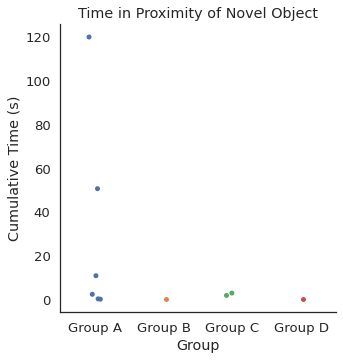

In [44]:
sns.catplot(data=res_object, x='Group', y='cumulative_time_in_roi_sec')

plt.ylabel('Cumulative Time (s)')
plt.title('Time in Proximity of Novel Object')

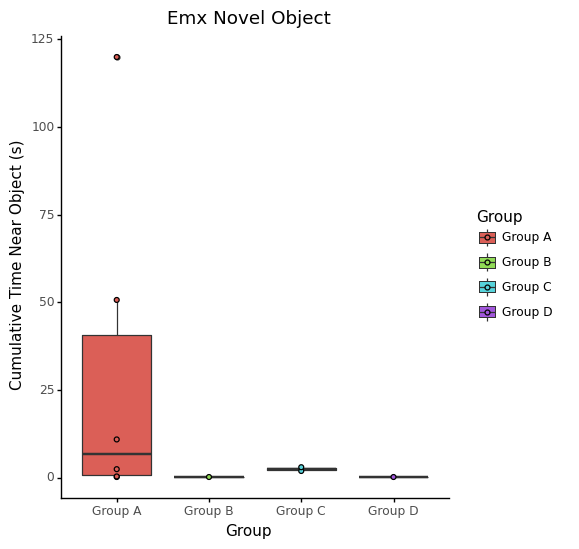

<ggplot: (8752446595256)>

In [45]:
import numpy as np
import pandas.api.types as pdtypes

from plotnine import *
from plotnine.data import *

%matplotlib inline

shift = 0.1

def alt_sign(x):
    "Alternate +1/-1 if x is even/odd"
    return (-1) ** x

#m1 = aes(x=stage('Genotype', after_scale='x+shift*alt_sign(x)'))              # shift outward
#m2 = aes(x=stage('Genotype', after_scale='x-shift*alt_sign(x)'))              # shift inward

(ggplot(res_object, aes(x='Group', y='cumulative_time_in_roi_sec', fill='Group'))
 + geom_boxplot()
 + geom_point()
 + theme_classic()
 + theme(figure_size=(5, 6))
 + ggtitle("Emx Novel Object")
 + ylab("Cumulative Time Near Object (s)")
)

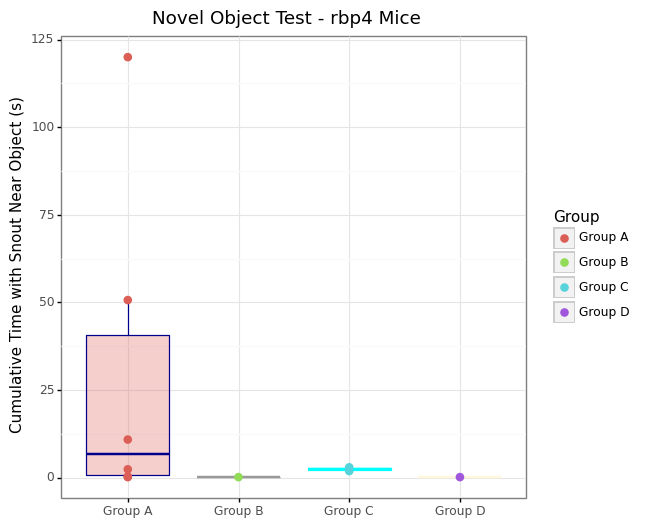

<ggplot: (8752439207518)>

In [51]:
(ggplot(data=res_object,
           mapping=aes(x='Group', y='cumulative_time_in_roi_sec', fill="Group"))
  + geom_boxplot(color=['darkblue', '#999999','cyan','cornsilk'], alpha=0.3, show_legend=False)
  + geom_point(color='none', size=3, alpha=1, show_legend=True)
  + scale_x_discrete(limits=['Group A','Group B','Group C','Group D'])
  + theme_bw()
  #+ scale_fill_manual(['#999999','#00008b'])
  + theme(figure_size=(6,6))
  + ggtitle("Novel Object Test - rbp4 Mice")
  + xlab("")
  + ylab("Cumulative Time with Snout Near Object (s)")
)

In [48]:
df = pd.read_hdf(Dataframes[5])

df = df[df.DLC_resnet50_topdown_homecage_novelobjectJul9shuffle1_190000.snout.likelihood != 0]

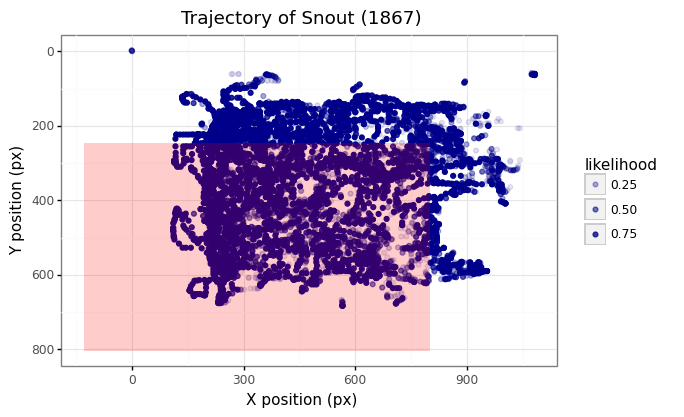

<ggplot: (8752439348601)>

In [49]:
#position scatterplot with plotnine

df = df["DLC_resnet50_topdown_homecage_novelobjectJul9shuffle1_190000"]["snout"]

from plotnine import *
from plotnine.data import *

rois = {'1867_ROI': position((-129, 246.857142857142), (801, 804.857142857142))} #example only!

#ROI rectangle values. Trust me, DeepLabCut draws its coordinates by inverting the y-axis.
x1 = rois['1867_ROI'].topleft[0]
x2 = rois['1867_ROI'].bottomright[0]
y1 = rois['1867_ROI'].topleft[1]
y2 = rois['1867_ROI'].bottomright[1]


(ggplot(df, aes(x='x', y='y', alpha='likelihood')) 
  + theme_bw()
  + scale_y_reverse()
  + coord_fixed()
  + geom_point(color='darkblue',)
  + annotate("rect", xmin=x1, xmax=x2, ymin=y1, ymax=y2,
             alpha=0.2, fill='red')
  + ggtitle("Trajectory of Snout (1867)")
  + xlab("X position (px)")
  + ylab("Y position (px)")
)

/home/mclea2ll-local/.conda/envs/jup_cresp_mclea/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 14 rows containing missing values.


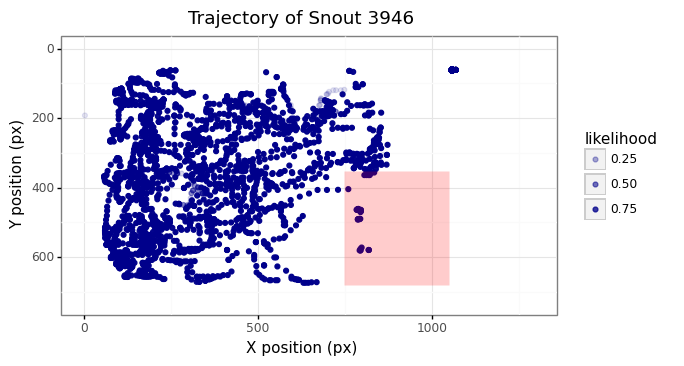

/home/mclea2ll-local/.conda/envs/jup_cresp_mclea/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 9 rows containing missing values.


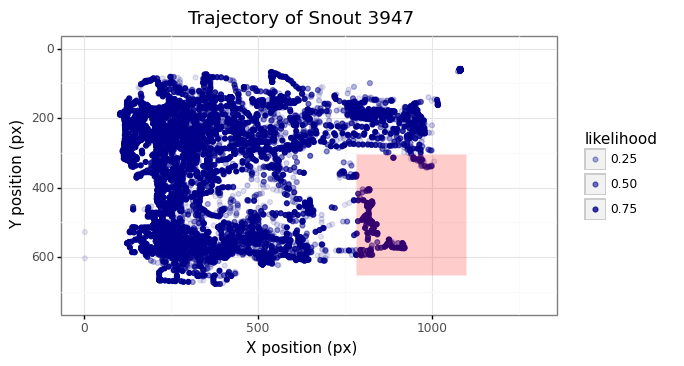

/home/mclea2ll-local/.conda/envs/jup_cresp_mclea/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 13 rows containing missing values.


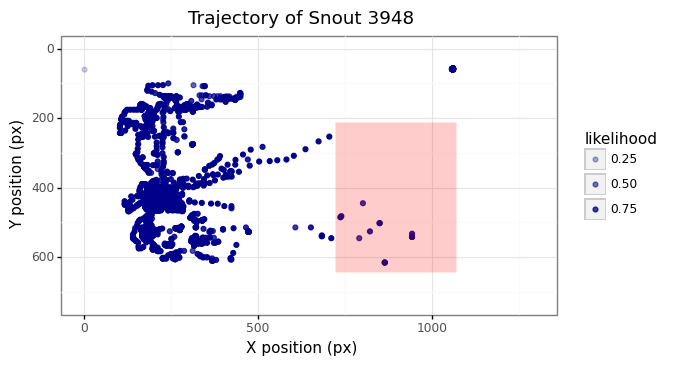

/home/mclea2ll-local/.conda/envs/jup_cresp_mclea/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 29 rows containing missing values.


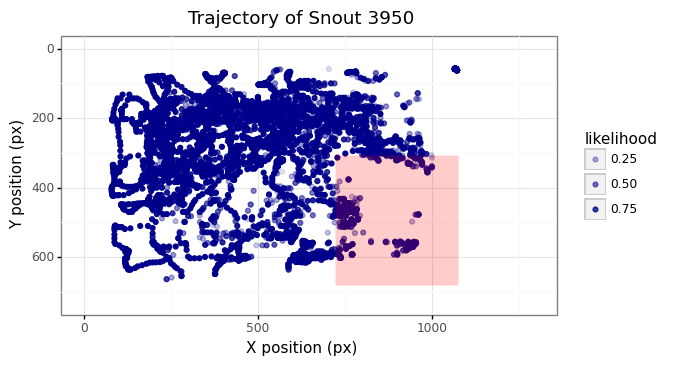

/home/mclea2ll-local/.conda/envs/jup_cresp_mclea/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 14 rows containing missing values.


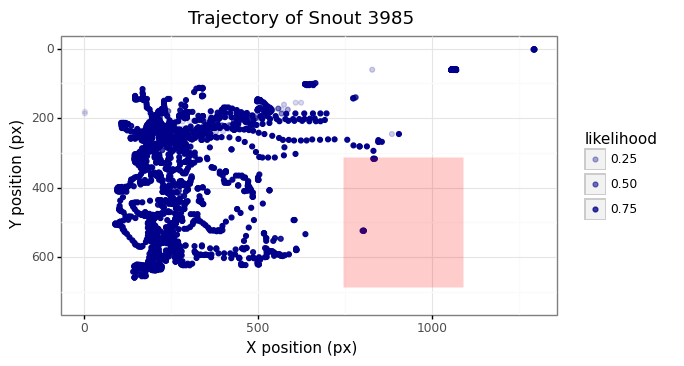

/home/mclea2ll-local/.conda/envs/jup_cresp_mclea/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 14 rows containing missing values.


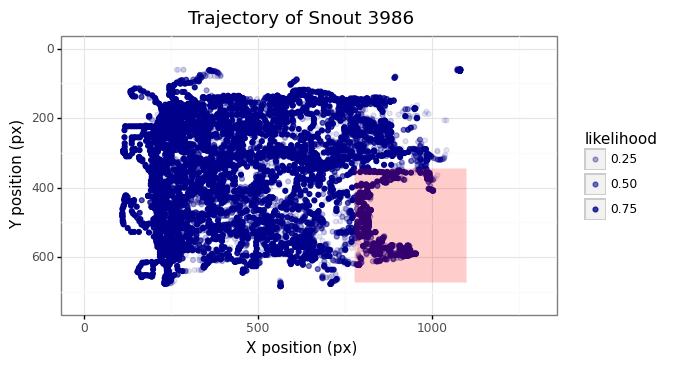

/home/mclea2ll-local/.conda/envs/jup_cresp_mclea/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 10 rows containing missing values.


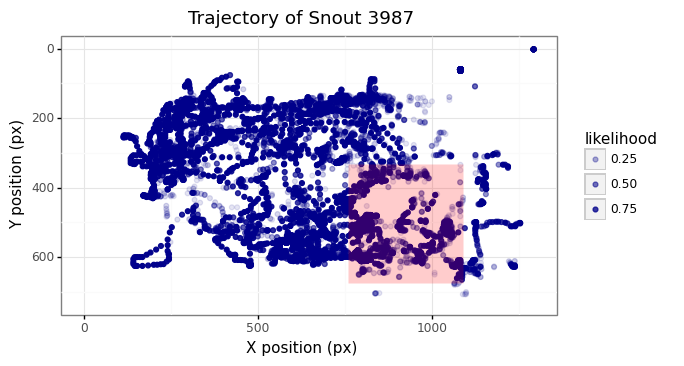

/home/mclea2ll-local/.conda/envs/jup_cresp_mclea/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 8 rows containing missing values.


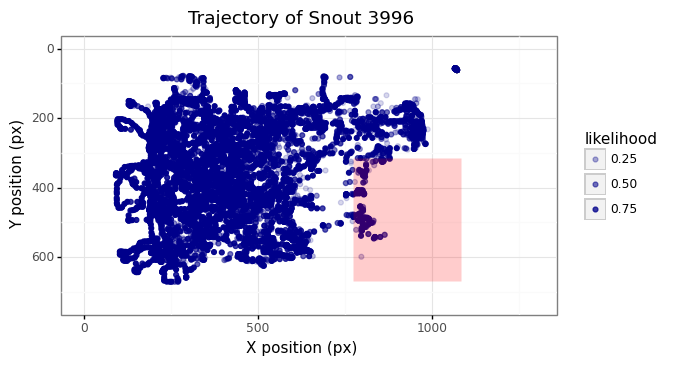

In [50]:
for Dataframe_path, id_num in zip(Dataframes, animal_ID_nums):
    Dataframe = pd.read_hdf(Dataframe_path)
    DLCscorer = Dataframe.T.index.values[0][0]
    Dataframe = Dataframe[Dataframe[DLCscorer]['snout']['likelihood'] != 0]
    Dataframe = Dataframe[DLCscorer]['snout']

    position = namedtuple('position', ['topleft', 'bottomright'])

    roi_save = roi_saves[roi_saves['ROI'] == id_num]
    roi_position = position((roi_save['TLX'], roi_save['TLY']), (roi_save['BRX'], roi_save['BRY']))
    rois = {str(id_num):roi_position}

    
    x1 = rois[str(id_num)].topleft[0]
    x2 = rois[str(id_num)].bottomright[0]
    y1 = rois[str(id_num)].topleft[1]
    y2 = rois[str(id_num)].bottomright[1]
    
    
    plot = (ggplot(Dataframe, aes(x = 'x', y = 'y', alpha='likelihood'))
      + theme_bw()
      + coord_fixed()
      + geom_point(color='darkblue',)
      + annotate("rect", xmin=x1, xmax=x2, ymin=y1, ymax=y2,
                 alpha=0.2, fill='red')
      + ggtitle("Trajectory of Snout (1867)")
      + ggtitle ("Trajectory of Snout " + (id_num))
      + xlab("X position (px)")
      + ylab("Y position (px)")
      + xlim(0, 1296)
      + ylim(0, 730)
      + theme(aspect_ratio=(9/16))
      + coord_trans(y='reverse')
    )
            
    print(plot)
    

In [ ]:
#p = ggplot(Dataframe, aes(x = 'x', y = 'y')) + geom_point()
#p + coord_cartesian(xlim = (0, 1000), ylim = (0, 1000))